In [1]:
from matplotlib import pyplot as plt
import numpy as np

from databroker import Broker
db = Broker.named('csx')

from ipywidgets import interact

def browse_images(res,title='Frame'):
    N = len(res)
    def view_image(i=0):
        im.set_data(res[i])
        ax.set_title(f'{title} {i}')
        fig.canvas.draw_idle()
    interact(view_image, i=(0, N-1))

Tiled version 0.1.0a120


# Using AXIS data at CSX with csxtools and how to access portions of saved data
## Notebooks created by CSX beamline staff
## Trust only the [source](https://github.com/ambarb/csx_primer_notebooks/blob/main/CSX_AXIS_data.ipynb) of this notebook
Report issues with this notebook on [github](https://github.com/ambarb/csx_primer_notebooks/issues) (aside from github rendering)

### Which axis detector version
- cycle 2025-1 and 2025-2
    - `axis1` is likely your detector
    - the images that are very low noise have some additional corrections that were automatically performed.  this was removed in 2025-2 at some point
    - 2025-2 was a time of transition due to rapid development of the axis 40x40 detector  
- cycle 2025-2 and 2025-3
    -  two versions `axis_standard` and `axis_cont`
       - `axis_cont` seems to perform better - be mindful first image is dropped so collection of other data is not at the exact same time
       - use the same detector for darks and lights


# How do we access the scans

Pretty much the same way, with slight differences.  Some of the old syntax does work.
- In this example, we use `axis_cont`.
- Some meta data may not exist for others (or earlier versions of `axis_cont` so be mindful.

**NOTE:  capablities are still growing.**

In [2]:
scan = 211161
scan_dark = 211162

scan_ff = 211163
scan_ff_dark = 211164 

det_name = "axis_cont"

### What modules in csxtools do we use
- the verson on the server will not work
- we can install from github direction using

`!pip install git+https://github.com/NSLS-II-CSX/csxtools.git`

- Until the version is avialbe, please run the cell below.
- Then select "Kernel", "Restart Kernel" and run the notebook again.
- This ensures the csxtools is correctly installed for all notebooks in your current session
- If you want to roll back: "File", "Hub Control", "Stop Server".

**Note:  the second time you run the cell below, it will provide instructions, but you can ignore those. Running the cell below isn't even required the second time.**  

In [15]:
pip install git+https://github.com/NSLS-II-CSX/csxtools.git

### Verify version
``` python
    import csxtools
    print(f'{csxtools.__version__=}')
```

```
    csxtools.__version__='0.2.1+142.g3a7071e'
```
**old version is '0.2.1'**

In [4]:
import csxtools
print(f'{csxtools.__version__=}')

csxtools.__version__='0.2.1+142.g3a7071e'


## After installing csxtools, you don't need to import it in every notebook

Use the cell below in all other notebooks

In [5]:
from csxtools.utils import get_axis_images, get_axis_flatfield

### HINT:  FOR AUTO-IMAGE CORRECTION PURPOSES
- take the dark you want to apply first.  This ensures full control of the applied dark
- otherwise, the dark closest in time, with the same exposure time, is utilized when light collection is complete.

**So here, 211162 will not be the dark applied in an automated pipeline to 211161.**

### Let's do it
- note, you can apply the flatfield by using `use_flatfield = True`

In [6]:
use_flatfield = False
use_flatfield = True

In [7]:
########### working part, don't touch
########### COPY PASTE IT 
h = db[scan] # h is for header

tbl=h.table() #get everything but IMAGES from AXIS
tbl_bl = h.table('baseline')

ADUpPH = None 
exptime = h.descriptors[0]['configuration'][det_name]['data'][det_name + '_cam_acquire_time']
frametime = h.descriptors[0]['configuration'][det_name]['data'][det_name + '_cam_acquire_period']
#det_tag = det_name + '_image'

if use_flatfield == False:
    ff = None
else:
    # below is pseudo code. you need to define the headers for this to work (uncomment these lines in the previous cell)
    ff = get_axis_flatfield(db[scan_ff], db[scan_ff], tag = det_name)

/nsls2/users/abarbour/.local/lib/python3.11/site-packages/csxtools/utils.py:369: RuntimeWarning: invalid value encountered in divide
  flat = np.nanmean(flat) / flat
Flatfield correction removed 16777216 pixels (100.00 %)


In [8]:
#get_axis1_flatfield?

### Lets get images normalized

In [9]:
images = get_axis_images(db[scan] , db[scan_dark], tag = det_name)

### If the above breaks, make sure you have the correct detector name:

In [10]:
print(f'detectors are {db[scan].start["detectors"] = }')
print(f'{det_name = }, which is configured by the users as a funtion argument')

detectors are db[scan].start["detectors"] = ['axis_cont']
det_name = 'axis_cont', which is configured by the users as a funtion argument


In [11]:
print(images.shape)

(31, 1, 4096, 4096)


## Currently, we cannot correct a portion of the image. This is a feature we are working on.

### If you want to do operations on a smaller piece loaded into memory by the functions, this should allow for some increase in speed

In [12]:
imgs = np.copy(images[:,:, 0:300, 0:300])
imgs.shape

(31, 1, 300, 300)

In [13]:
%matplotlib widget

interactive(children=(IntSlider(value=0, description='i', max=30), Output()), _dom_classes=('widget-interact',…

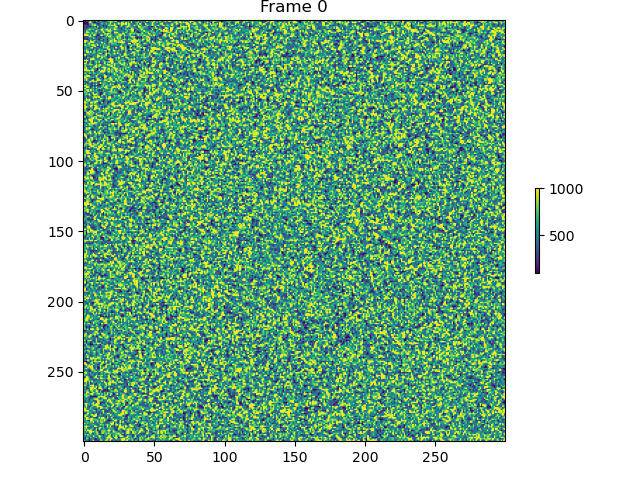

In [14]:
imgs = np.squeeze(imgs)
fig = plt.figure()
ax = plt.gca()
im = ax.imshow(imgs[0], vmin = 100, vmax=1_000)
plt.colorbar(im, ax=ax, shrink=.2)
plt.tight_layout()
browse_images(imgs)

### Save for later??
- one option are using `np.save()` and `np.load()`, but it is the whole array
- another is h5py.  you can open specific slices this way, but use a context manager (`with`) so you can open the file if soemthing goes wrong.  h5 file remain open otherwise, and you cannot "reopen"

## Want to know more about skbeam and XPCS or roi functions:

See the end of the notebook [CSX_fccd_data.ipynb](https://github.com/ambarb/csx_primer_notebooks/blob/main/CSX_fccd_data.ipynb).